### Natural Language Processing demo

### Original by @EmmanuelAmeisen (Insight AI)
* [original repo here](https://github.com/hundredblocks/concrete_NLP_tutorial)

In [1]:
import nltk

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import re

In [5]:
# https://docs.python.org/3/library/codecs.html
import codecs

In [6]:
import keras

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Sanitizing input
Let's make sure our tweets only have characters we want. Remove '#' characters but keep trailing text for possible relevance (eg: #disaster)

In [7]:
input_file = codecs.open("socialmedia_relevant_cols.csv", "r", encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

### Inspect the data
* We don't really need urls
* All lowercase (Hello and HELLO are pretty similar for our task)

In [13]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [14]:
questions.tail()

,text,choose_one,class_label
10854,1.3 #Earthquake in 9Km Ssw Of Anza California ...,Relevant,1
10855,Evacuation order lifted for town of Roosevelt:...,Relevant,1
10856,See the 16yr old PKK suicide bomber who detona...,Relevant,1
10857,To conference attendees! The blue line from th...,Relevant,1
10858,The death toll in a #IS-suicide car bombing on...,Relevant,1


In [15]:
questions.describe()

,class_label
count,10859.000000
mean,0.431808
std,0.498317
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


Use regular expressions to clean the data & save it to disk

In [16]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [17]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10854,10854,1 3 earthquake in 9km ssw of anza california ...,Relevant,1
10855,10855,evacuation order lifted for town of roosevelt,Relevant,1
10856,10856,see the 16yr old pkk suicide bomber who detona...,Relevant,1
10857,10857,to conference attendees! the blue line from th...,Relevant,1
10858,10858,the death toll in a is suicide car bombing on...,Relevant,1


### Data Overview

Let's look at our class balance.

In [13]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6186,6186,6186
1,4657,4657,4657
2,16,16,16


### Data Prep
- Tokenize sentences to a list of separate words
- Create a train/test split
- Inspect data to validate results

In [19]:
#http://www.nltk.org/api/nltk.tokenize.html
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [21]:
# https://keras.io/preprocessing/text/
from keras.preprocessing.text     import Tokenizer

# https://keras.io/preprocessing/sequence/
from keras.preprocessing.sequence import pad_sequences

# https://keras.io/utils/
from keras.utils                  import to_categorical

all_words        = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB            = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154484 words total, with a vocabulary size of 18095
Max sentence length is 34


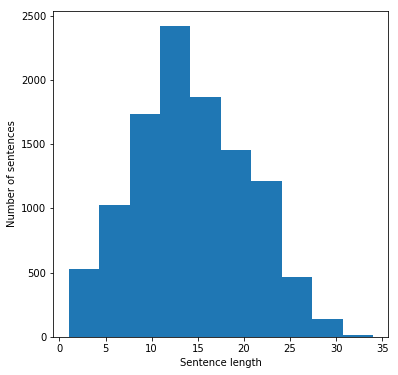

In [24]:
# histogram of sentence lengths

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6,6)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

### Enter embeddings
 
* The simplest approach is to use a bag of words model & apply a logistic regression. A BOW associates an index to each word in the vocabulary & embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

### Bag of Words Counts

In [25]:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    list_corpus, 
    list_labels, 
    test_size=0.2, 
    random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts                    = count_vectorizer.transform(X_test)

### Visualize embeddings
* Hopefully our embeddings will show that the classes are perfectly separated. 
* Since visualizing data in 20k dimensions is hard, let's project it down to 2.

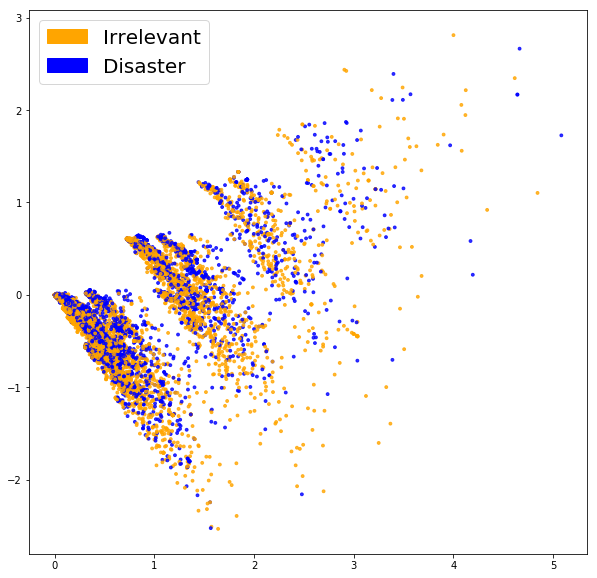

In [27]:
# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition
# Principal component analysis (PCA): Linear dimensionality reduction using Singular Value Decomposition
#     to project it to a lower dimensional space.
# TruncatedSVD: Dimensionality reduction using truncated SVD (aka LSA).

from sklearn.decomposition import PCA, TruncatedSVD

# https://matplotlib.org/api/patches_api.html
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        
        if plot:
            plt.scatter(
                lsa_scores[:,0], 
                lsa_scores[:,1], 
                s=8, 
                alpha=.8, 
                c=test_labels, 
                cmap=matplotlib.colors.ListedColormap(colors))
            
            red_patch   = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue',   label='Disaster')
            
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

fig = plt.figure(figsize=(10,10))          
plot_LSA(X_train_counts, y_train)
plt.show()

* These embeddings don't look very cleanly separated. Let's fit a useful model on them.

### Fitting a classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [28]:
# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    C=30.0,                     # Inverse of regularization strength. Smaller values = stronger regularization.
    class_weight='balanced',    # dict or ‘balanced’. If not given, all classes are supposed to have weight one.
    solver='newton-cg',         # {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
    multi_class='multinomial', 
    n_jobs=-1, 
    random_state=40)

clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

### Accuracy, Precision, Recall & F1 metrics

In [33]:
# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):
    
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, 
                                y_predicted, 
                                pos_label=None,
                                average='weighted')  
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, 
                          y_predicted, 
                          pos_label=None,
                          average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, 
                  y_predicted, 
                  pos_label=None, 
                  average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, 
                              y_predicted)
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761 
precision = 0.758 
recall = 0.761 
f1 = 0.759


### Confusion Matrix

In [46]:
import numpy as np

# https://docs.python.org/3/library/itertools.html - Functions creating iterators for efficient looping
import itertools

# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(
        range(cm.shape[0]), 
        range(cm.shape[1])):
        
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", 
                 fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label',      fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

    return plt

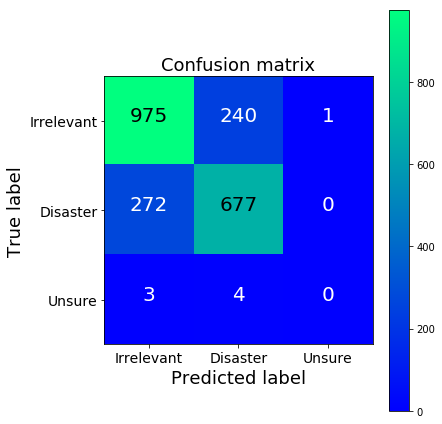

[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [48]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6,6))
plot = plot_confusion_matrix(
    cm, 
    classes=['Irrelevant','Disaster','Unsure'], 
    normalize=False, 
    title='Confusion matrix')

plt.show()
print(cm)

* Our classifier creates more false negatives than false positives. This may be OK depending on the use case.

### What features are being using to make decisions?

In [52]:
def get_most_important_features(vectorizer, model, n=5):

    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    
    for class_index in range(model.coef_.shape[0]):
        
        word_importances = [(el, index_to_word[i]) 
                            for i,el in enumerate(
                                model.coef_[class_index])]
        
        sorted_coeff = sorted(
            word_importances, 
            key = lambda x : x[0], 
            reverse=True)
        
        tops = sorted(
            sorted_coeff[:n], 
            key = lambda x : x[0])
        
        bottom = sorted_coeff[-n:]
        
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(
    count_vectorizer, 
    clf, 
    10)

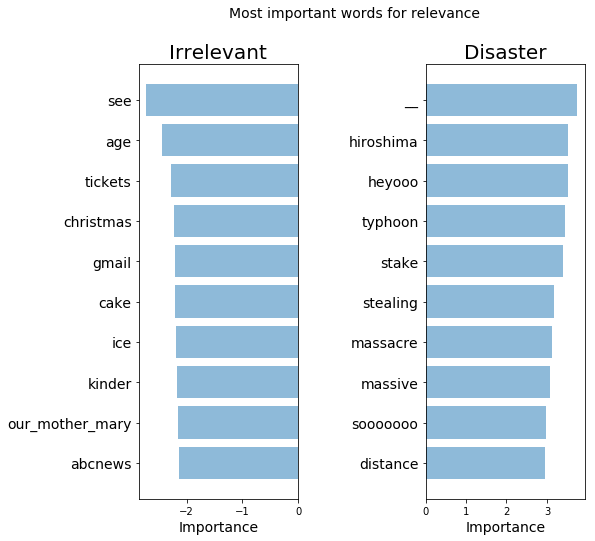

In [53]:
def plot_important_words(
    top_scores,    top_words, 
    bottom_scores, bottom_words, 
    name):
    
    y_pos     = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words  = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words  = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(8,8))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=14)
    plt.xlabel('Importance', fontsize=14)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=14)
    plt.xlabel('Importance', fontsize=14)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores    = [a[0] for a in importance[1]['tops']]
top_words     = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words  = [a[1] for a in importance[1]['bottom']]

plot_important_words(
    top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

* The classifier correctly detects some patterns (hiroshima, massacre), but seems to be overfitting on some irellevant terms (heyoo, for example.)

### TFIDF Bag of Words Approach

* On top of our BOW model, let's use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting too-frequent words such as a, the, ....

In [54]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# Convert a collection of raw documents to a matrix of TF-IDF features.
# Equivalent to CountVectorizer followed by TfidfTransformer.

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

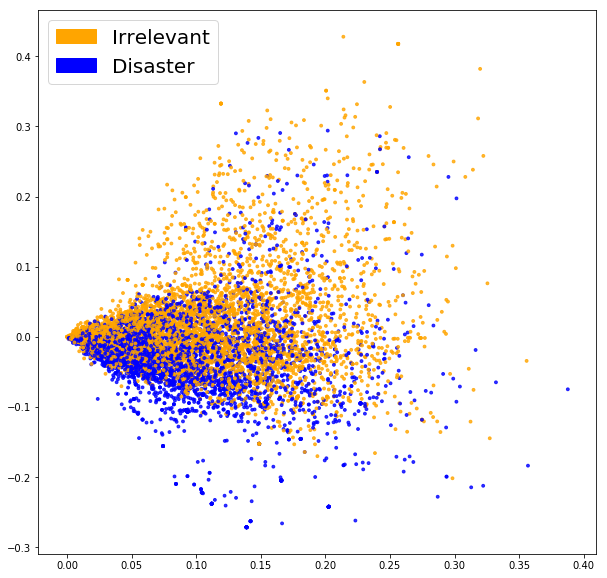

In [55]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

* The separation looks better. Let's refit to a logistic regression model & recheck the metrics.

In [56]:
clf_tfidf = LogisticRegression(
    C=30.0, 
    class_weight='balanced', 
    solver='newton-cg', 
    multi_class='multinomial', 
    n_jobs=-1, 
    random_state=40)

clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [57]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, 
                                                                      y_predicted_tfidf)

print("accuracy = %.3f\nprecision = %.3f\nrecall = %.3f\nf1 = %.3f" % (accuracy_tfidf, 
                                                                       precision_tfidf, 
                                                                       recall_tfidf, 
                                                                       f1_tfidf))

accuracy = 0.760
precision = 0.757
recall = 0.760
f1 = 0.758


/home/bjpcjp/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bjpcjp/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* Hmmm, nearly unchanged. Let's see the confusion matrix.

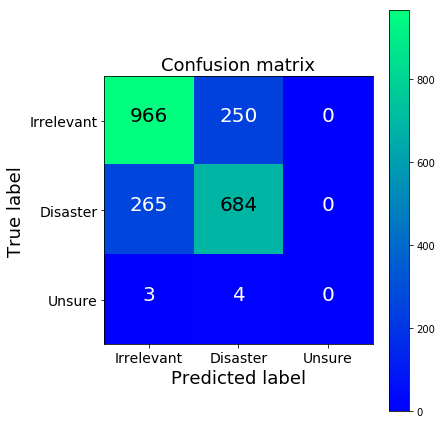

TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [59]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(6,6))
plot = plot_confusion_matrix(
    cm2, 
    classes=['Irrelevant','Disaster','Unsure'], 
    normalize=False, 
    title='Confusion matrix')

plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### Looking at important coefficients for linear regression

In [60]:
importance_tfidf = get_most_important_features(
    tfidf_vectorizer, 
    clf_tfidf, 
    10)

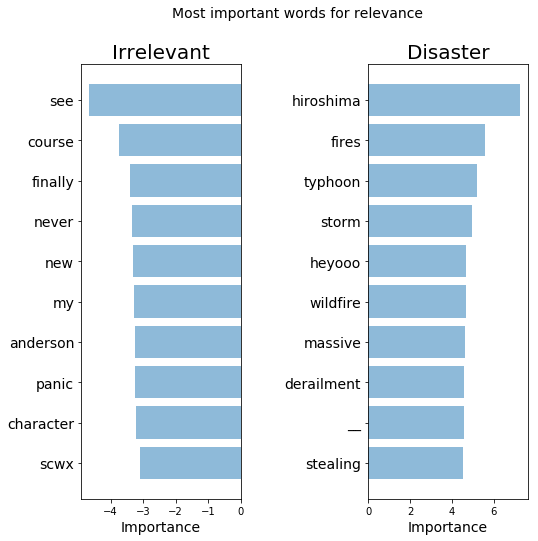

In [62]:
top_scores =    [a[0] for a in importance_tfidf[1]['tops']]
top_words =     [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words =  [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(
    top_scores,       top_words, 
    bottom_scores, bottom_words, 
    "Most important words for relevance")

* Although our metrics on our held out validation set haven't improved much, we can have more confidence in the terms our model is using, and thus would feel more comfortable deploying it in a system that would interact with customers.

### Capturing semantic meaning

* Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. 

* To solve this problem, we need to capture the __semantic__ meaning of words. We need to understand that words like 'good' and 'positive' are closer than 'apricot' and 'continent'.

* __Word2vec__ is a model that was pre-trained on a very large corpus. It provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier is to average word2vec scores of all words in our sentence.

### Dataset: Disasters on social media
Contributors looked at over 10K tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous). Thank you [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

* Download GoogleNews dataset (very large): http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

In [63]:
# https://radimrehurek.com/gensim/ - topic modeling for humans
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [67]:
def get_average_word2vec(
    tokens_list, 
    vector, 
    generate_missing=False, 
    k=300):
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) 
                      for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) 
                      for word in tokens_list]
    
    length   = len(vectorized)
    summed   = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    
    return averaged

def get_word2vec_embeddings(
    vectors, 
    clean_questions, 
    generate_missing=False):
    
    embeddings = clean_questions['tokens'].apply(
        lambda x: get_average_word2vec(
            x, 
            vectors, 
            generate_missing=generate_missing))
    
    return list(embeddings)

In [69]:
embeddings = get_word2vec_embeddings(
    word2vec, 
    clean_questions)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    embeddings, 
    list_labels, 
    test_size=0.2, 
    random_state=40)

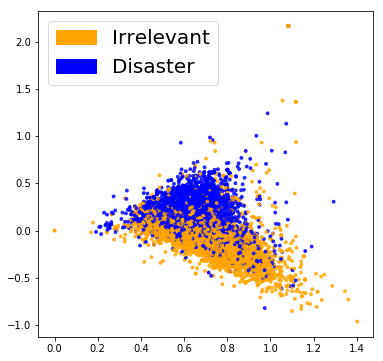

In [70]:
fig = plt.figure(figsize=(6,6))          
plot_LSA(embeddings, list_labels)
plt.show()

* Much more separation. Let's see what logistic regression has to say.

In [71]:
clf_w2v = LogisticRegression(
    C=30.0, 
    class_weight='balanced', 
    solver='newton-cg',
    multi_class='multinomial', 
    random_state=40)

clf_w2v.fit(
    X_train_word2vec, 
    y_train_word2vec)

y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [72]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(
    y_test_word2vec, 
    y_predicted_word2vec)

print("accuracy = %.3f\n precision = %.3f\n recall = %.3f\n f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.772
 precision = 0.772
 recall = 0.772
 f1 = 0.772


* A little better. Let's see the confusion matrix.

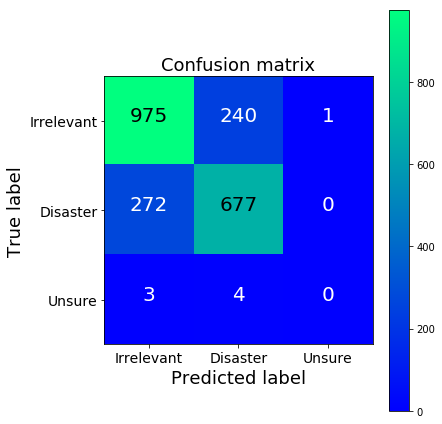

Word2Vec confusion matrix
[[982 229   5]
 [250 694   5]
 [  2   5   0]]
TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [73]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(6,6))
plot = plot_confusion_matrix(
    cm, 
    classes=['Irrelevant','Disaster','Unsure'], 
    normalize=False, 
    title='Confusion matrix')

plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### Further inspection

* Since our classifier does not use a vector with one dimension per word, it's much harder to see which words are most relevant. 
* Let's use a black box explainer (LIME) to provide some clarity.

In [74]:
# https://github.com/marcotcr/lime
from lime             import lime_text
from lime.lime_text   import LimeTextExplainer

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline
from sklearn.pipeline import make_pipeline

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
    list_corpus, 
    list_labels, 
    test_size=0.2, 
    random_state=40)

vector_store = word2vec

def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        
        vectorized_example = get_average_word2vec(
            example_tokens, 
            vector_store, 
            generate_missing=False, 
            k=300)
        
        tokenized_list.append(vectorized_example)
    
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [75]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(
        class_names=class_names)
    
    exp = explainer.explain_instance(
        instance, 
        word2vec_pipeline, 
        num_features=6)
    
    return exp

def visualize_one_exp(
    features, 
    labels, 
    index, 
    class_names = ["irrelevant","relevant", "unknown"]):
    
    exp = explain_one_instance(
        features[index], 
        class_names = class_names)
    
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [76]:
visualize_one_exp(X_test_data, y_test_data, 65)

/home/bjpcjp/miniconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 65
True class: relevant


In [77]:
visualize_one_exp(X_test_data, y_test_data, 60)

/home/bjpcjp/miniconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 60
True class: relevant


In [79]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors        = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
    
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

/home/bjpcjp/miniconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


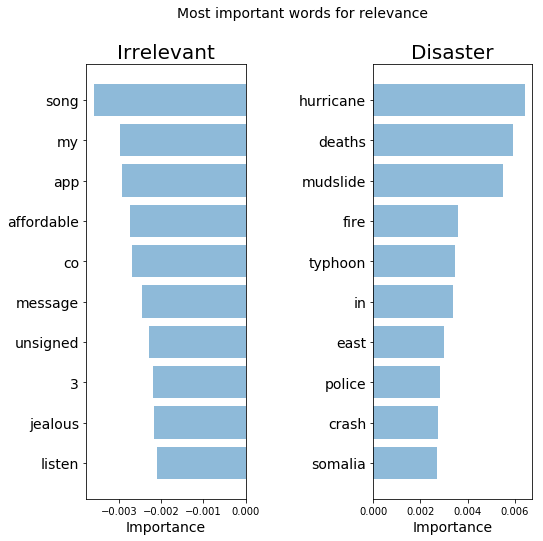

In [80]:
# First index:  the class (Disaster)
# Second index: 0 for detractors, 1 for supporters
# Third index:  how many words we sample

top_words =     sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores =    sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words =  sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(
    top_scores,    top_words, 
    bottom_scores, bottom_words, 
    "Most important words for relevance")

* It looks like relevant words are being picked up.

### CNNs for text classification

* Our models are OK, but they completely ignore sentence structure.

* Here, we use a Convolutional Neural Network for sentence classification. While not as popular as RNNs, they have been proven to get competitive results (sometimes beating the best models), and are very fast to train, making them a perfect choice for this tutorial.

In [81]:
# https://keras.io/preprocessing/text/
# Class for vectorizing texts, or/and turning texts into sequences 
# (=list of word indexes, where the word of rank i in the dataset 
# (starting at 1) has index i).
from keras.preprocessing.text     import Tokenizer

# https://keras.io/preprocessing/sequence/
# Transform a list of num_samples sequences (lists of scalars) 
# into a 2D Numpy array of shape (num_samples, num_timesteps)
from keras.preprocessing.sequence import pad_sequences

# Converts a class vector (integers) to binary class matrix.
# for use with categorical_crossentropy.
from keras.utils                  import to_categorical


EMBEDDING_DIM       = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE          = len(VOCAB)
VALIDATION_SPLIT    = 0.2
tokenizer           = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts(
    clean_questions["text"].tolist())

sequences  = tokenizer.texts_to_sequences(
    clean_questions["text"].tolist())

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(
    sequences, 
    maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(
    np.asarray(
        clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels   = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros(
    (len(word_index)+1, 
     EMBEDDING_DIM))

for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print(embedding_weights.shape)

Found 19091 unique tokens.
(19092, 300)


### Define a simple Convolutional Neural Network

In [82]:
from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(
    embeddings, 
    max_sequence_length, 
    num_words, 
    embedding_dim, 
    labels_index, 
    trainable=False, 
    extra_conv=True):
    
    embedding_layer = Embedding(
        num_words,
        embedding_dim,
        weights=[embeddings],
        input_length=max_sequence_length,
        trainable=trainable)

    sequence_input = Input(
        shape=(max_sequence_length,), 
        dtype='int32')
    
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model
    # https://arxiv.org/abs/1408.5882 == Convolutional Neural Networks for Sentence Classification
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(
            filters=128, 
            kernel_size=filter_size, 
            activation='relu')(embedded_sequences)
        
        l_pool = MaxPooling1D(
            pool_size=3)(l_conv)
        
        convs.append(l_pool)

    l_merge = Merge(
        mode='concat', 
        concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(
        filters=128, 
        kernel_size=3, 
        activation='relu')(embedded_sequences)
    
    pool = MaxPooling1D(
        pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(
        labels_index, 
        activation='softmax')(x)

    model = Model(
        sequence_input, 
        preds)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

### Training

In [83]:
x_train = cnn_data[:-num_validation_samples]
x_val =   cnn_data[-num_validation_samples:]

y_train = labels[:-num_validation_samples]
y_val =   labels[-num_validation_samples:]

model = ConvNet(
    embedding_weights, 
    MAX_SEQUENCE_LENGTH, 
    len(word_index)+1, 
    EMBEDDING_DIM, 
    len(list(clean_questions["class_label"].unique())), 
    False)

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [84]:
model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val), 
    epochs=3, 
    batch_size=128)

Train on 8688 samples, validate on 2171 samples
Epoch 1/3
8688/8688 [==============================] - 13s 1ms/step - loss: 0.6049 - acc: 0.7005 - val_loss: 0.4655 - val_acc: 0.7959
Epoch 2/3
8688/8688 [==============================] - 12s 1ms/step - loss: 0.4532 - acc: 0.8006 - val_loss: 0.4397 - val_acc: 0.8121
Epoch 3/3
8688/8688 [==============================] - 13s 1ms/step - loss: 0.3996 - acc: 0.8280 - val_loss: 0.4358 - val_acc: 0.8167


### Text generation
* Most text problems require organizing or classifying text data.
* In some cases (automated support systems, translation, etc.) we need to generate text.
* One of the best methods to accomplish this is to use a Recurrent Neural Network as a language model. 
* Training these models is quite difficult, and usually very long. 
* Since we will not have time to train one here, below is an example of a pre-trained model.

### Yelp review generation

* This is a character-level Recurrent Neural Network model trained by Andrew Manser (an Insight Fellow), during his time at insight. He used 5 star reviews from the open Yelp dataset.
* Download the dataset: _curl -O https://s3.amazonaws.com/yelp-weights-files/Sep-26-all-00-0.7280.hdf5_
* Rename as pretrained-yelp.hdf5_

In [87]:
# code from https://github.com/ajmanser/Yelp

from keras import layers
import sys

# Dictionary mapping unique characters to their index in `chars`
text=open('seed_text.txt').read()
chars=['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

char_indices = dict((char, chars.index(char)) for char in chars)
maxlen=60
step=1

model = keras.models.Sequential()
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.load_weights("pretrained-yelp.hdf5")

optimizer = keras.optimizers.Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [88]:
def sample(preds, temperature=1.0):
    
    preds     = np.asarray(preds).astype('float64')
    preds     = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds     = exp_preds / np.sum(exp_preds)
    probas    = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def random_reviews():
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with several reviews for you...')

    for temperature in [0.8]:
        sys.stdout.write(generated_text)

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print(generated_text)

In [89]:
random_reviews()

Coming up with several reviews for you...
ile.  This file is just something to help the model get started.

/home/bjpcjp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<EOR>"
"<SOR>The food is great. The service is very friendly the food always arrives quickly and the portions are huge! My wife and I have eaten here at least 2 times a week to watch and sit on the patio. Been here for several years and never disappointed. Reminds me of me tropical fast food now for some unique and conversations!!! service is friendly and helpful with the good quality food for the price. The price is just right.<EOR>"
"<SOR>This is the best seafood ever just delicious. I had the flan, my hubby leers spicy shrimp - super good service and the chicken fried rice is to die for super good service and the chicken fried rice is to die for


### Making Deep Learning models better
* It's useful to add hand-crafter rules. Here we substitute food words in the generated reviews for ones from a pre-established list.

In [90]:
# http://www.nltk.org/howto/wordnet.html
# WordNet is just another NLTK corpus reader

from nltk.corpus import wordnet as wn

def food_related(nouns):

    food=wn.synset('food.n.01')
    final_list=[]
    for word in nouns:
        temp=word
        word=word+'.n.01'
        try:
            if food.wup_similarity(wn.synset(word))>0.20 and temp!='food':
                final_list.append(temp)
        except:
            pass

    return final_list

def user_custom(foods):

    # enter foods as a string separated by commas. For example 'sushi, sashimi, maki'
    start_index    = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with two ideas for you...')

    final=generated_text+''

    for temperature in [0.8]:

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            final+=next_char

            generated_text += next_char
            generated_text = generated_text[1:]
    
    #print first review, then second via SOR/EOR
    temp=personalized_clean_up(final, foods)
    start=temp.find('SOR')
    stop=findStrAfterStr(temp, 'EOR', 'SOR')
    end_first=temp[start+4:stop]

    new=temp[get_second_index(temp, 'SOR')+4:]
    ending=new.find('EOR')
    print(temp[start+4:stop])
    print("")
    print(new[:ending])
    
def personalized_clean_up(review,user_items):
    #take generic review, and replace with user generated words
    generic_nouns=review_to_nouns(review)
    food_generic=food_related(generic_nouns)

    user_picked_items=user_items.split(",")

    final=[]
    for word in re.findall(r"[\w']+|[.,!?;]", review):
        if word in food_generic and len(user_picked_items)>1:
            word=np.random.choice(user_picked_items)
            final.append(word)
        else:
            final.append(word)

    new_review=" ".join(final)
    return re.sub(r'\s+([?.!",])', r'\1', new_review)

def review_to_nouns(review):
    is_noun = lambda pos: pos[:2] == 'NN'
    token=nltk.word_tokenize(review)
    nouns=[word for (word, pos) in nltk.pos_tag(token) if is_noun(pos)]
    return nouns

def findStrAfterStr(myString, searchText, afterText):
    after_index = myString.index(afterText)
    return myString.find(searchText, after_index)

def get_second_index(input_string, sub_string):
    return input_string.index(sub_string, input_string.index(sub_string) + 1)

In [91]:
# load from NLTK Data repo: http://www.nltk.org/nltk_data/

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/bjpcjp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bjpcjp/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/bjpcjp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [92]:
user_custom('burrito, taco, guac')

Coming up with two ideas for you...


/home/bjpcjp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Excellent service and food that couldn't have been more tasty. I'd go again soon. 

 taco  guac to come for some rare burrito and  guac! We were seated very quickly. 
